# H-1B Prevailing Wage Project — Notebook 2  
## 02_Preprocessing_Modeling_and_Experiments.ipynb
 
In this notebook we perform:  
**feature engineering (NLP + structured) → train & compare 5+ models → tuning (Optuna) → SHAP + error analysis → unsupervised (KMeans + DBSCAN) → executive summary.**


In [1]:
# =============================================================================
# 1. Imports & Setup
# =============================================================================
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

# Text & preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD

# Models
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

# CatBoost (optional - if installed)
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# Tuning
import optuna

# Unsupervised
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Interpretability
import shap

# Config
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path("data")
REPORTS_DIR = Path("reports")
FIGURES_DIR = REPORTS_DIR / "figures"
MODELS_DIR = Path("models")

REPORTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

plt.rcParams["figure.figsize"] = (10, 6)

def save_show(fig_name: str):
    out_path = FIGURES_DIR / fig_name
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def evaluate(y_true, y_pred):
    return {
        "rmse_log1p": rmse(y_true, y_pred),
        "mae_log1p": float(mean_absolute_error(y_true, y_pred)),
        "r2_log1p": float(r2_score(y_true, y_pred)),
    }

print("✅ Notebook 2 setup complete.")

✅ Notebook 2 setup complete.


## 2) Load split data (Train/Val/Test)

Load the splits saved by Notebook 1 and show a preview (required).


In [2]:
# =============================================================================
# 2. Load splits
# =============================================================================
train_df = pd.read_csv(DATA_DIR / "train.csv", low_memory=False)
val_df   = pd.read_csv(DATA_DIR / "val.csv", low_memory=False)
test_df  = pd.read_csv(DATA_DIR / "test.csv", low_memory=False)

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)
display(train_df.head(5))

print("\nTop missing columns (train):")
display(train_df.isna().sum().sort_values(ascending=False).head(10))

Train: (332252, 18)  Val: (41532, 18)  Test: (41532, 18)


,CASE_STATUS,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,EMPLOYER_NAME,EMPLOYER_STATE,NAICS_CODE,WORKSITE_CITY,WORKSITE_STATE,WAGE_UNIT_OF_PAY,prev_wage,PW_UNIT_OF_PAY,H_1B_DEPENDENT,WILLFUL_VIOLATOR,y_reg
0,Certified,NaN,H-1B,Software Engineering,Software Developers,Y,1.0,Microsoft Corporation,WA,513210.0,Redmond,WA,Year,163862.0,Year,No,No,12.006786
1,Certified,NaN,H-1B,Network Engineer,Network and Computer Systems Administrators,Y,1.0,Safeway Inc.,CA,445110.0,Anchorage,AK,Year,78624.0,Year,No,No,11.272445
2,Certified,NaN,H-1B,Software Engineer,Software Developers,Y,20.0,"ServiceNow, Inc.",CA,541511.0,Santa Clara,CA,Year,132785.0,Year,No,No,11.796494
3,Certified,NaN,H-1B,Gitlab Engineer,Software Developers,Y,1.0,Ingenious Heads LLC,VA,541511.0,Richardson,TX,Year,105997.0,Year,Yes,No,11.571176
4,Certified,NaN,H-1B,Senior Research Finance Manager,Natural Sciences Managers,Y,1.0,Memorial Sloan Kettering Cancer Center,NY,622310.0,Brooklyn,NY,Year,98509.0,Year,No,No,11.497913



Top missing columns (train):


ORIGINAL_CERT_DATE    332252
WILLFUL_VIOLATOR        6302
H_1B_DEPENDENT          6301
EMPLOYER_STATE           100
CASE_STATUS                0
WORKSITE_CITY              0
PW_UNIT_OF_PAY             0
prev_wage                  0
WAGE_UNIT_OF_PAY           0
WORKSITE_STATE             0
dtype: int64

## 3) Minimal feature set + seniority features

We define core features (per proposal):  
- `JOB_TITLE` (text)  
- `WORKSITE_STATE` (categorical)  
- `EMPLOYER_NAME` (high-cardinality → target mean encoding)  

We also add simple **seniority keyword features** extracted from the title using regex.


In [3]:
# CODE BY GPT
# =============================================================================
# 3. Columns + simple seniority features
# =============================================================================
# Flexible column names
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

JOB_COL = pick_first_existing(train_df, ["JOB_TITLE", "job_title"])
STATE_COL = pick_first_existing(train_df, ["WORKSITE_STATE", "EMPLOYER_STATE"])
EMP_COL = pick_first_existing(train_df, ["EMPLOYER_NAME", "employer_name"])
TARGET_COL = pick_first_existing(train_df, ["y_reg"])
WAGE_COL = pick_first_existing(train_df, ["prev_wage"])

missing = [("JOB_TITLE", JOB_COL), ("STATE", STATE_COL), ("EMPLOYER", EMP_COL), ("TARGET(y_reg)", TARGET_COL)]
for name, col in missing:
    if col is None:
        print(f"⚠️ Missing expected column: {name}")

assert TARGET_COL is not None, "y_reg must exist (created in Notebook 1)."

def add_seniority_flags(df: pd.DataFrame, job_col: str) -> pd.DataFrame:
    out = df.copy()
    t = out[job_col].fillna("").astype(str).str.lower()
    out["is_senior"] = t.str.contains(r"\bsenior\b|\bsr\b|\bsr\.")
    out["is_junior"] = t.str.contains(r"\bjunior\b|\bjr\b|\bjr\.")
    out["is_manager"] = t.str.contains(r"\bmanager\b|\bmg?r\b|\bdirector\b|\bhead\b")
    out["is_lead"] = t.str.contains(r"\blead\b|\bteam lead\b")
    out["is_principal"] = t.str.contains(r"\bprincipal\b|\bstaff\b|\barchitect\b")
    return out

train_df = add_seniority_flags(train_df, JOB_COL)
val_df   = add_seniority_flags(val_df, JOB_COL)
test_df  = add_seniority_flags(test_df, JOB_COL)

# Required preview in Notebook 2
preview_cols = [c for c in [JOB_COL, STATE_COL, EMP_COL, WAGE_COL, TARGET_COL] if c is not None]
preview_cols += ["is_senior", "is_manager", "is_principal"]
display(train_df[preview_cols].head())

,JOB_TITLE,WORKSITE_STATE,EMPLOYER_NAME,prev_wage,y_reg,is_senior,is_manager,is_principal
0,Software Engineering,WA,Microsoft Corporation,163862.0,12.006786,False,False,False
1,Network Engineer,AK,Safeway Inc.,78624.0,11.272445,False,False,False
2,Software Engineer,CA,"ServiceNow, Inc.",132785.0,11.796494,False,False,False
3,Gitlab Engineer,TX,Ingenious Heads LLC,105997.0,11.571176,False,False,False
4,Senior Research Finance Manager,NY,Memorial Sloan Kettering Cancer Center,98509.0,11.497913,True,True,False


## 4) Text features (TF-IDF) + State One-Hot + Employer Mean Encoding

Main feature engineering:  
1) TF-IDF on `JOB_TITLE` (uni+bi-grams, max_features 20k–25k)  
2) One-Hot for state  
3) Employer mean encoding **without leakage** (train-only stats)  
4) Add seniority flags (5 binary columns)


In [4]:
# CODE BY GPT
# =============================================================================
# 4. Feature engineering
# =============================================================================
# (A) TF-IDF
tfidf = TfidfVectorizer(
    max_features=25000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2
)

X_train_text = tfidf.fit_transform(train_df[JOB_COL].fillna(""))
X_val_text   = tfidf.transform(val_df[JOB_COL].fillna(""))
X_test_text  = tfidf.transform(test_df[JOB_COL].fillna(""))

print("TF-IDF shapes:", X_train_text.shape, X_val_text.shape, X_test_text.shape)
print("Example TF-IDF features:", tfidf.get_feature_names_out()[:20])

# (B) One-Hot for state (compat across sklearn versions)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

X_train_state = ohe.fit_transform(train_df[[STATE_COL]].fillna("UNKNOWN"))
X_val_state   = ohe.transform(val_df[[STATE_COL]].fillna("UNKNOWN"))
X_test_state  = ohe.transform(test_df[[STATE_COL]].fillna("UNKNOWN"))

print("State OHE shapes:", X_train_state.shape, X_val_state.shape, X_test_state.shape)

# (C) Employer mean encoding (train-only)
global_mean = float(train_df[TARGET_COL].mean())
emp_means = train_df.groupby(EMP_COL)[TARGET_COL].mean()

def encode_employer(df_):
    return df_[EMP_COL].map(emp_means).fillna(global_mean).astype(float).values.reshape(-1, 1)

X_train_emp = encode_employer(train_df)
X_val_emp   = encode_employer(val_df)
X_test_emp  = encode_employer(test_df)

# (D) Seniority flags (dense small)
flag_cols = ["is_senior", "is_junior", "is_manager", "is_lead", "is_principal"]
X_train_flags = train_df[flag_cols].astype(int).values
X_val_flags   = val_df[flag_cols].astype(int).values
X_test_flags  = test_df[flag_cols].astype(int).values

# Combine (sparse)
from scipy.sparse import hstack, csr_matrix

X_train_sparse = hstack([X_train_text, X_train_state, csr_matrix(X_train_emp), csr_matrix(X_train_flags)]).tocsr()
X_val_sparse   = hstack([X_val_text,   X_val_state,   csr_matrix(X_val_emp),   csr_matrix(X_val_flags)]).tocsr()
X_test_sparse  = hstack([X_test_text,  X_test_state,  csr_matrix(X_test_emp),  csr_matrix(X_test_flags)]).tocsr()

y_train = train_df[TARGET_COL].values
y_val   = val_df[TARGET_COL].values
y_test  = test_df[TARGET_COL].values

print("Final sparse shapes:", X_train_sparse.shape, X_val_sparse.shape, X_test_sparse.shape)

# Required preview AFTER preprocessing
print("\nPreview after preprocessing:")
print("X_train_sparse shape:", X_train_sparse.shape)
print("Non-zeros in first row:", X_train_sparse[0].nnz)
print("TF-IDF vocabulary size:", len(tfidf.get_feature_names_out()))


TF-IDF shapes: (332252, 25000) (41532, 25000) (41532, 25000)
Example TF-IDF features: ['00' '000013' '001753' '002418' '017040' '0180' '043029' '070774'
 '076084' '081398' '10' '100' '100 adlrgsales' '100 adtech' '11' '11525'
 '118' '12' '12 grade' '12 math']
State OHE shapes: (332252, 55) (41532, 55) (41532, 55)
Final sparse shapes: (332252, 25061) (41532, 25061) (41532, 25061)

Preview after preprocessing:
X_train_sparse shape: (332252, 25061)
Non-zeros in first row: 5
TF-IDF vocabulary size: 25000


## 5) Supervised models 
 
Per proposal we compare **5 supervised models**:  
1) Linear Regression (baseline)  
2) Random Forest  
3) XGBoost  
4) CatBoost  
5) Stacking Regressor  

Technical note: RandomForest struggles with huge sparse TF-IDF, so for RF/Stacking/CatBoost we use **TruncatedSVD (LSA)** to get a compact dense representation. XGBoost is trained directly on sparse (best model).


In [5]:
# CODE BY GPT
# =============================================================================
# 5. Dense representation for models that can't handle huge sparse TF-IDF
# =============================================================================
# Fit SVD ONLY on train text to avoid leakage
SVD_COMPONENTS = 300

svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=SEED)
X_train_text_svd = svd.fit_transform(X_train_text)
X_val_text_svd   = svd.transform(X_val_text)
X_test_text_svd  = svd.transform(X_test_text)

# State OHE is small; convert to dense for these models
X_train_state_dense = X_train_state.toarray()
X_val_state_dense   = X_val_state.toarray()
X_test_state_dense  = X_test_state.toarray()

# Combine dense features
X_train_dense = np.hstack([X_train_text_svd, X_train_state_dense, X_train_emp, X_train_flags])
X_val_dense   = np.hstack([X_val_text_svd,   X_val_state_dense,   X_val_emp,   X_val_flags])
X_test_dense  = np.hstack([X_test_text_svd,  X_test_state_dense,  X_test_emp,  X_test_flags])

print("Dense shapes:", X_train_dense.shape, X_val_dense.shape, X_test_dense.shape)

Dense shapes: (332252, 361) (41532, 361) (41532, 361)


Starting supervised model training...
1) LinearRegression...
2) RandomForest...
3) XGBoost (sparse)...
CatBoost not available -> skipping (install via: pip install catboost).
5) StackingRegressor (safe mode: cv=3, n_jobs=1)...


,model,rmse_log1p,mae_log1p,r2_log1p
2,XGBoost,0.217695,0.149345,0.646002
0,LinearRegression (baseline),0.232155,0.163926,0.597413
1,RandomForest,0.234481,0.158225,0.589306
3,Stacking (RF + XGB),0.238531,0.166961,0.574997


Saved metrics to: reports\metrics.csv


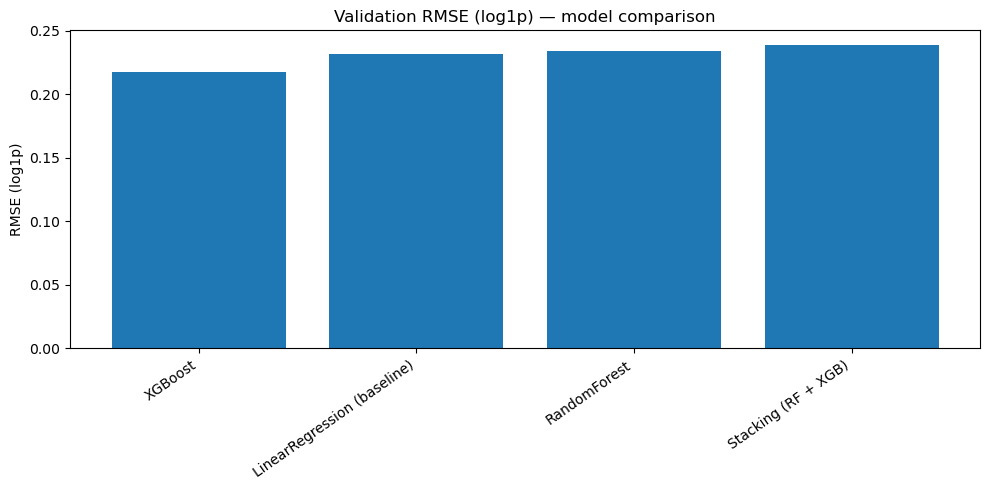

In [7]:
# =============================================================================
# 5B. Train & compare supervised models (Memory & Speed safe)
# =============================================================================
import gc

# Optional: try install CatBoost ONCE if needed (comment out if already installed)
# !pip install -q catboost

# Check CatBoost availability
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

# Reduce memory footprint for dense matrices (recommended)
X_train_dense = X_train_dense.astype(np.float32, copy=False)
X_val_dense   = X_val_dense.astype(np.float32, copy=False)

results = []
print("Starting supervised model training...")

# 1) Linear Regression baseline (dense)
print("1) LinearRegression...")
lin = LinearRegression()
lin.fit(X_train_dense, y_train)
pred = lin.predict(X_val_dense)
results.append({"model": "LinearRegression (baseline)", **evaluate(y_val, pred)})

gc.collect()

# 2) Random Forest (dense) - optimized
print("2) RandomForest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train_dense, y_train)
pred = rf.predict(X_val_dense)
results.append({"model": "RandomForest", **evaluate(y_val, pred)})

del rf
gc.collect()

# 3) XGBoost (sparse) - main candidate
print("3) XGBoost (sparse)...")
xgb_base = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=SEED,
    tree_method="hist"
)
xgb_base.fit(X_train_sparse, y_train)
pred = xgb_base.predict(X_val_sparse)
results.append({"model": "XGBoost", **evaluate(y_val, pred)})

gc.collect()

# 4) CatBoost (dense) - if available
if CATBOOST_AVAILABLE:
    print("4) CatBoost...")
    cat = CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        random_seed=SEED,
        loss_function="RMSE",
        verbose=False,
        allow_writing_files=False
    )
    cat.fit(X_train_dense, y_train)
    pred = cat.predict(X_val_dense)
    results.append({"model": "CatBoost", **evaluate(y_val, pred)})

    del cat
    gc.collect()
else:
    print("CatBoost not available -> skipping (install via: pip install catboost).")

# 5) Stacking (dense) -- SAFE MODE (prevents MemoryError)
print("5) StackingRegressor (safe mode: cv=3, n_jobs=1)...")

rf_stack = RandomForestRegressor(
    n_estimators=50,
    max_depth=6,
    random_state=SEED,
    n_jobs=1
)

xgb_stack = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=1,
    random_state=SEED,
    tree_method="hist"
)

estimators = [("rf", rf_stack), ("xgb", xgb_stack)]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=3,
    n_jobs=1
)

stack.fit(X_train_dense, y_train)
pred = stack.predict(X_val_dense)
results.append({"model": "Stacking (RF + XGB)", **evaluate(y_val, pred)})

# --- Summary ---
results_df = pd.DataFrame(results).sort_values("rmse_log1p")
display(results_df)

# Save metrics
metrics_path = REPORTS_DIR / "metrics.csv"
results_df.to_csv(metrics_path, index=False)
print("Saved metrics to:", metrics_path)

# Plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["rmse_log1p"])
plt.title("Validation RMSE (log1p) — model comparison")
plt.ylabel("RMSE (log1p)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


## 6) Hyperparameter tuning for XGBoost (Optuna)

To get strong performance (~0.20 RMSE), we tune XGBoost with Optuna.  
For practicality, control runtime with `N_TRIALS`.


In [9]:
# CODE BY GPT
# =============================================================================
# 6. Optuna tuning (XGBoost on sparse) - VERSION SAFE (uses callbacks)
# =============================================================================
import gc
# --- Make sure dirs exist ---
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

N_TRIALS = 15   # good for deadline

def fit_xgb_with_es(model, X_tr, y_tr, X_va, y_va, rounds=50):
    """
    Version-safe early stopping:
    - Try callbacks (works in newer XGBoost versions)
    - If callbacks not supported, train without early stopping (still works, just slower)
    """
    try:
        es_cb = [xgb.callback.EarlyStopping(rounds=rounds, save_best=True)]
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False,
            callbacks=es_cb
        )
        return True
    except TypeError:
        # Fallback: no early stopping support in this environment
        model.fit(X_tr, y_tr)
        return False

def xgb_predict_best(model, X):
    """
    Predict using the best iteration if available (handles multiple XGBoost versions).
    """
    # Newer versions: iteration_range
    try:
        best_iter = getattr(model, "best_iteration", None)
        if best_iter is not None:
            return model.predict(X, iteration_range=(0, best_iter + 1))
    except TypeError:
        pass

    # Older versions: best_ntree_limit
    try:
        best_ntree_limit = getattr(model, "best_ntree_limit", None)
        if best_ntree_limit is not None:
            return model.predict(X, ntree_limit=best_ntree_limit)
    except TypeError:
        pass

    # Default
    return model.predict(X)

def objective(trial):
    params = {
        "n_estimators": 5000,  # big cap; early stopping (if supported) will stop earlier
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "n_jobs": -1,
        "random_state": SEED,
        "tree_method": "hist",
    }

    model = xgb.XGBRegressor(**params)

    _ = fit_xgb_with_es(model, X_train_sparse, y_train, X_val_sparse, y_val, rounds=50)
    pred = xgb_predict_best(model, X_val_sparse)

    score = rmse(y_val, pred)

    del model
    gc.collect()
    return score

print("Starting Optuna...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_params
best_value = study.best_value

print("Best trial RMSE:", best_value)
print("Best params:", best_params)

# Save best params (models/ + reports/)
best_params_path_models = MODELS_DIR / "best_params_xgboost.json"
best_params_path_reports = REPORTS_DIR / "best_params_xgboost.json"

with open(best_params_path_models, "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)
with open(best_params_path_reports, "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)

print("Saved:", best_params_path_models)
print("Saved:", best_params_path_reports)

# ---- Train final tuned model (same safe early stopping logic) ----
print("Training Final Tuned XGBoost...")
xgb_tuned = xgb.XGBRegressor(
    **best_params,
    n_estimators=5000,
    n_jobs=-1,
    random_state=SEED,
    tree_method="hist"
)

_ = fit_xgb_with_es(xgb_tuned, X_train_sparse, y_train, X_val_sparse, y_val, rounds=50)

pred_val  = xgb_predict_best(xgb_tuned, X_val_sparse)
pred_test = xgb_predict_best(xgb_tuned, X_test_sparse)

val_metrics  = evaluate(y_val, pred_val)
test_metrics = evaluate(y_test, pred_test)

print("VAL:", val_metrics)
print("TEST:", test_metrics)

# Save test metrics
with open(REPORTS_DIR / "test_metrics_xgboost.json", "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, indent=2)
print("Saved:", REPORTS_DIR / "test_metrics_xgboost.json")


[I 2026-01-06 16:50:44,291] A new study created in memory with name: no-name-88a4aca3-eaac-4f89-96e7-81ba7ee6e8f5


Starting Optuna...


[I 2026-01-06 16:57:09,086] Trial 0 finished with value: 0.21859666494516236 and parameters: {'learning_rate': 0.023374085146245848, 'max_depth': 4, 'min_child_weight': 0.018811301684304286, 'subsample': 0.7805692285077317, 'colsample_bytree': 0.719242536955569, 'reg_alpha': 2.43374452159389, 'reg_lambda': 6.080089007293203}. Best is trial 0 with value: 0.21859666494516236.
[I 2026-01-06 17:07:36,395] Trial 1 finished with value: 0.208979768931756 and parameters: {'learning_rate': 0.13178261464467156, 'max_depth': 5, 'min_child_weight': 0.019294438274034036, 'subsample': 0.9928298249983009, 'colsample_bytree': 0.9665445460307795, 'reg_alpha': 0.5382503448683418, 'reg_lambda': 5.426705964214116}. Best is trial 1 with value: 0.208979768931756.
[I 2026-01-06 17:13:54,051] Trial 2 finished with value: 0.22291516549626855 and parameters: {'learning_rate': 0.012103798491859535, 'max_depth': 4, 'min_child_weight': 6.967284907698032, 'subsample': 0.6499793478565667, 'colsample_bytree': 0.81282

KeyboardInterrupt: 

In [10]:
# =============================================================================
# MANUAL RESCUE: Run this ONLY after stopping the Optuna cell manually
# =============================================================================
print("Manually stopped Optuna. Recovering results so far...")

# Sanity: make sure we have at least 1 successful trial
ok_trials = [t for t in study.trials if t.value is not None]
print("Trials finished:", len(study.trials))
print("Successful trials:", len(ok_trials))

if len(ok_trials) == 0:
    raise RuntimeError("No successful Optuna trials found — cannot recover best params.")

best_params = study.best_params
best_value = study.best_value

print(f"Best RMSE so far (val, log1p): {best_value:.6f}")
print("Best params:", best_params)

# --- Ensure dirs exist ---
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Save best params ---
best_params_path_models  = MODELS_DIR / "best_params_xgboost.json"
best_params_path_reports = REPORTS_DIR / "best_params_xgboost.json"

with open(best_params_path_models, "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)
with open(best_params_path_reports, "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)

print("Saved best params to:")
print(" -", best_params_path_models)
print(" -", best_params_path_reports)

# --- Save trials table (very useful for report) ---
trials_df = study.trials_dataframe()
trials_csv = REPORTS_DIR / "optuna_trials_xgboost.csv"
trials_df.to_csv(trials_csv, index=False)
print("Saved trials CSV:", trials_csv)

# --- Train final tuned model (same helpers you already defined) ---
print("Training FINAL tuned XGBoost (using best params so far)...")

xgb_tuned = xgb.XGBRegressor(
    **best_params,
    n_estimators=5000,      # large cap; ES will stop early if supported
    n_jobs=-1,
    random_state=SEED,
    tree_method="hist"
)

_ = fit_xgb_with_es(xgb_tuned, X_train_sparse, y_train, X_val_sparse, y_val, rounds=50)

pred_val  = xgb_predict_best(xgb_tuned, X_val_sparse)
pred_test = xgb_predict_best(xgb_tuned, X_test_sparse)

val_metrics  = evaluate(y_val, pred_val)
test_metrics = evaluate(y_test, pred_test)

print("FINAL RESULTS")
print("VAL:", val_metrics)
print("TEST:", test_metrics)

# Save test metrics
test_metrics_path = REPORTS_DIR / "test_metrics_xgboost.json"
with open(test_metrics_path, "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, indent=2)
print("Saved final test metrics to:", test_metrics_path)

gc.collect()


Manually stopped Optuna. Recovering results so far...
Trials finished: 12
Successful trials: 11
Best RMSE so far (val, log1p): 0.208499
Best params: {'learning_rate': 0.054309054853750934, 'max_depth': 9, 'min_child_weight': 0.13069880403624762, 'subsample': 0.9691510504920645, 'colsample_bytree': 0.6128744217546239, 'reg_alpha': 6.253133196067637, 'reg_lambda': 3.2379198587384534}
Saved best params to:
 - models\best_params_xgboost.json
 - reports\best_params_xgboost.json
Saved trials CSV: reports\optuna_trials_xgboost.csv
Training FINAL tuned XGBoost (using best params so far)...
FINAL RESULTS
VAL: {'rmse_log1p': 0.20849897664788314, 'mae_log1p': 0.1388966658090202, 'r2_log1p': 0.6752788218769898}
TEST: {'rmse_log1p': 0.2084707803996967, 'mae_log1p': 0.13929993459851434, 'r2_log1p': 0.6759536641371566}
Saved final test metrics to: reports\test_metrics_xgboost.json


253

## 7) Learning curve (quick diagnostic)
 
We create a simple learning curve:  
train on increasing subset sizes and evaluate RMSE on Train and Validation.


Generating Learning Curve...


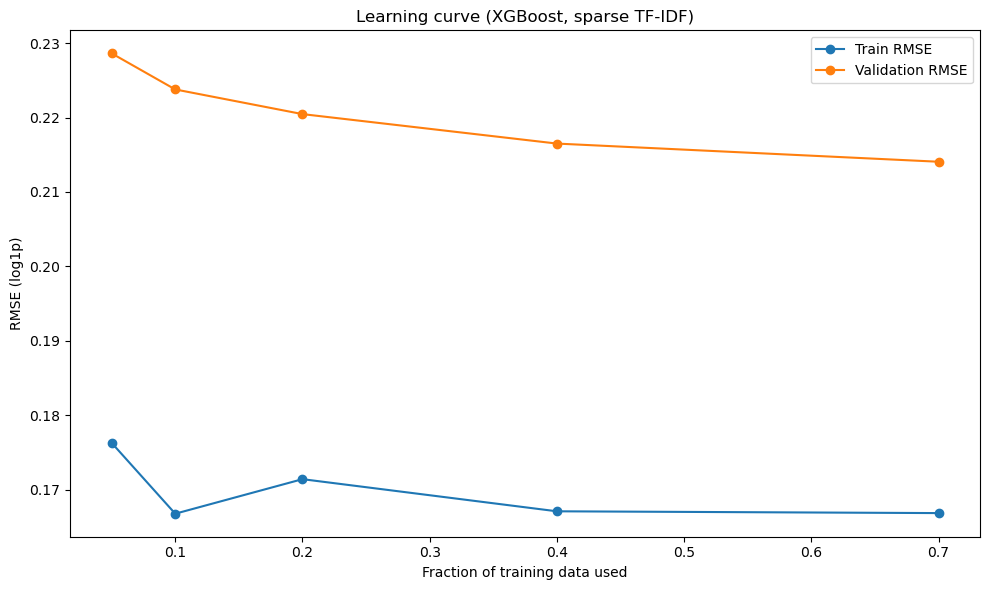

Saved: reports\figures\learning_curve_xgb_sparse.png


In [12]:
# CODE BY GPT
# =============================================================================
# 7. Learning curve (subset-based) - SAFE (version-proof + faster)
# =============================================================================
from sklearn.utils import resample

subset_fracs = [0.05, 0.10, 0.20, 0.40, 0.70]  # אפשר להוסיף 1.0 אם ממש חייבים
train_rmse, val_rmse = [], []

n = X_train_sparse.shape[0]
idx_all = np.arange(n)

print("Generating Learning Curve...")

for frac in subset_fracs:
    m = int(n * frac)
    idx = resample(idx_all, n_samples=m, replace=False, random_state=SEED)

    model = xgb.XGBRegressor(
        **best_params,
        n_estimators=1200,        # cap קטן יותר
        n_jobs=-1,
        random_state=SEED,
        tree_method="hist"
    )

    # ✅ version-safe early stopping (your helper)
    _ = fit_xgb_with_es(model, X_train_sparse[idx], y_train[idx], X_val_sparse, y_val, rounds=30)

    # ✅ predict using best iteration if available
    pred_tr = xgb_predict_best(model, X_train_sparse[idx])
    pred_va = xgb_predict_best(model, X_val_sparse)

    train_rmse.append(rmse(y_train[idx], pred_tr))
    val_rmse.append(rmse(y_val, pred_va))

    del model
    gc.collect()

plt.figure()
plt.plot(subset_fracs, train_rmse, marker="o", label="Train RMSE")
plt.plot(subset_fracs, val_rmse, marker="o", label="Validation RMSE")
plt.title("Learning curve (XGBoost, sparse TF-IDF)")
plt.xlabel("Fraction of training data used")
plt.ylabel("RMSE (log1p)")
plt.legend()
save_show("learning_curve_xgb_sparse.png")

## 8) Interpretability (SHAP) + Error Analysis
 
Use SHAP for:  
- Global explanations (top features)  
- Local examples (best & worst cases)  
Plus error analysis by wage deciles and by top states.


C:\Users\USER\AppData\Local\Temp\ipykernel_4908\1669112593.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False, max_display=20)


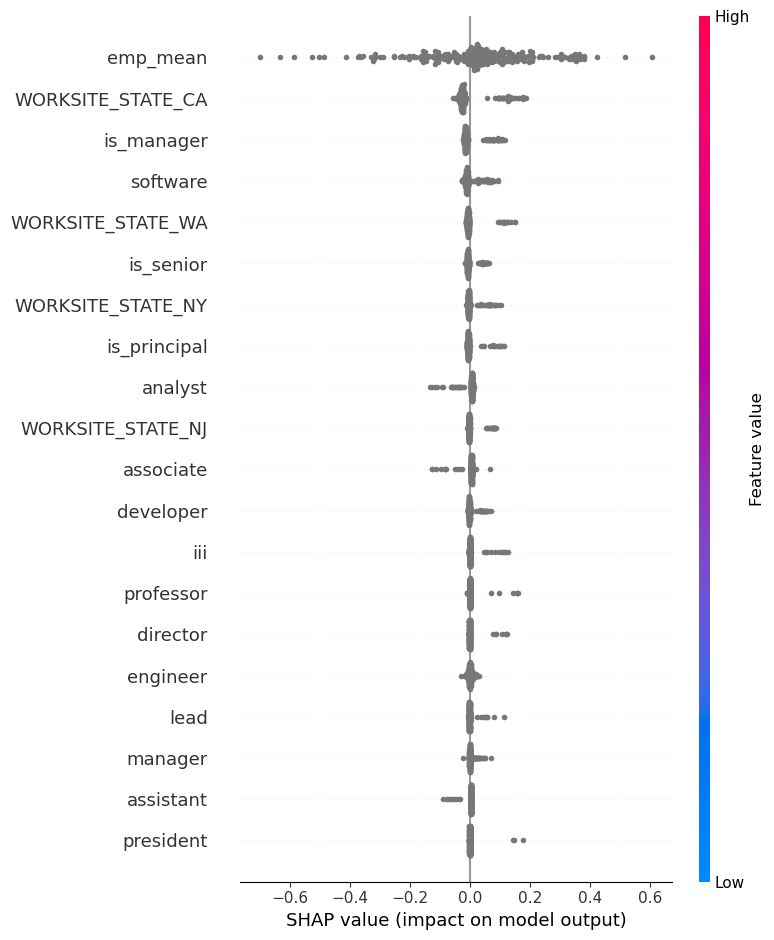

Saved: reports\figures\shap_summary_beeswarm.png


C:\Users\USER\AppData\Local\Temp\ipykernel_4908\1669112593.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type="bar", show=False, max_display=20)


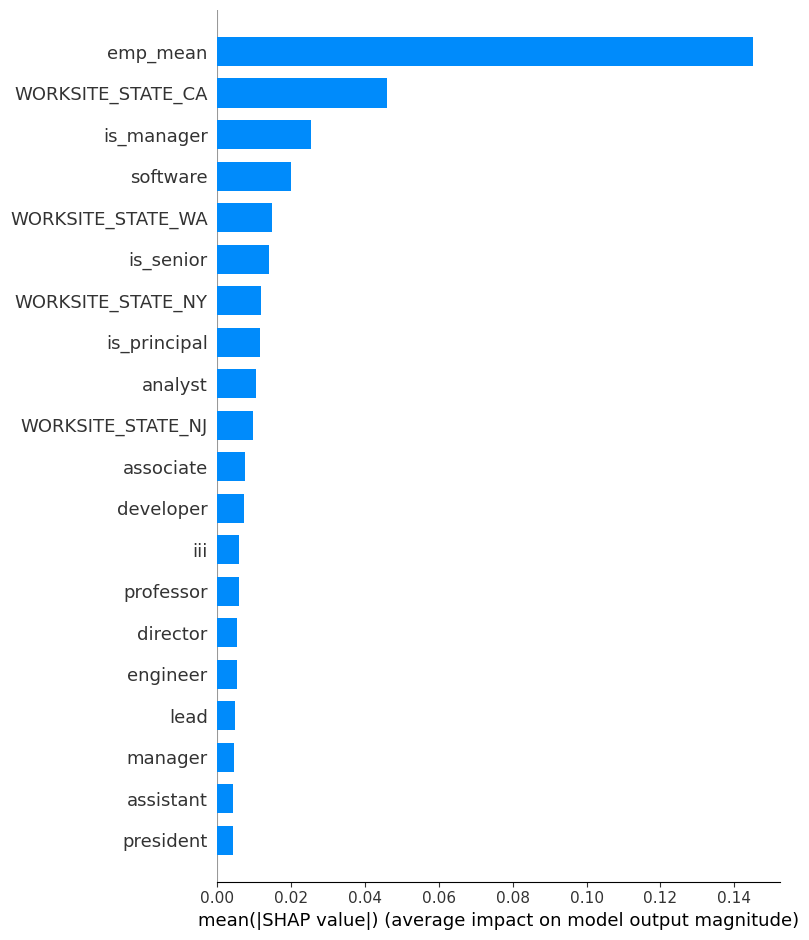

Saved: reports\figures\shap_importance_bar.png


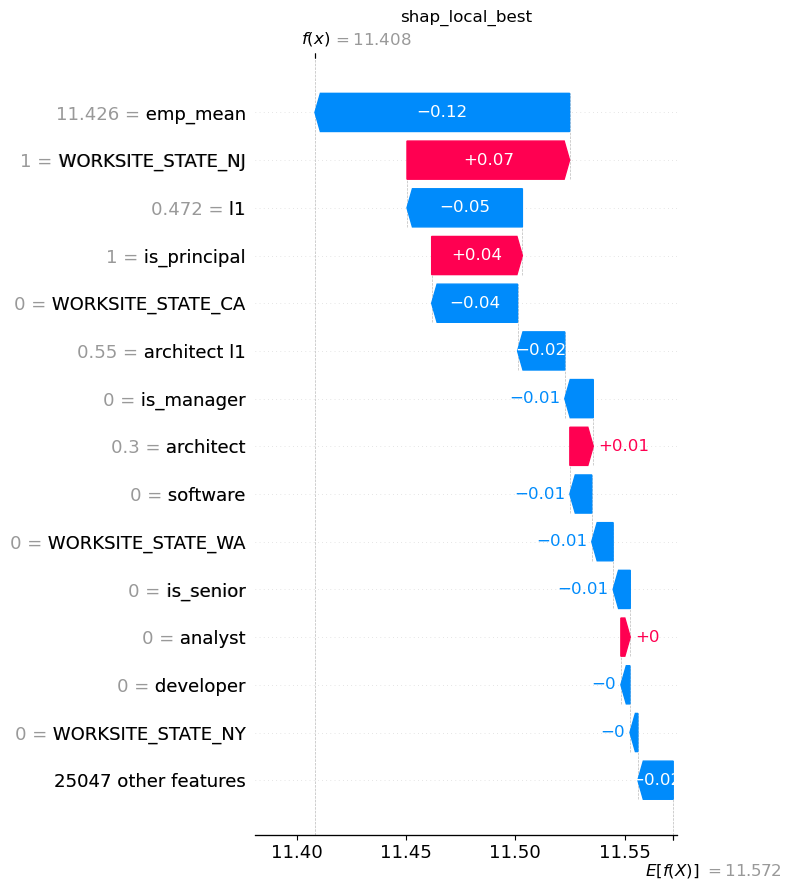

Saved: reports\figures\shap_local_best.png


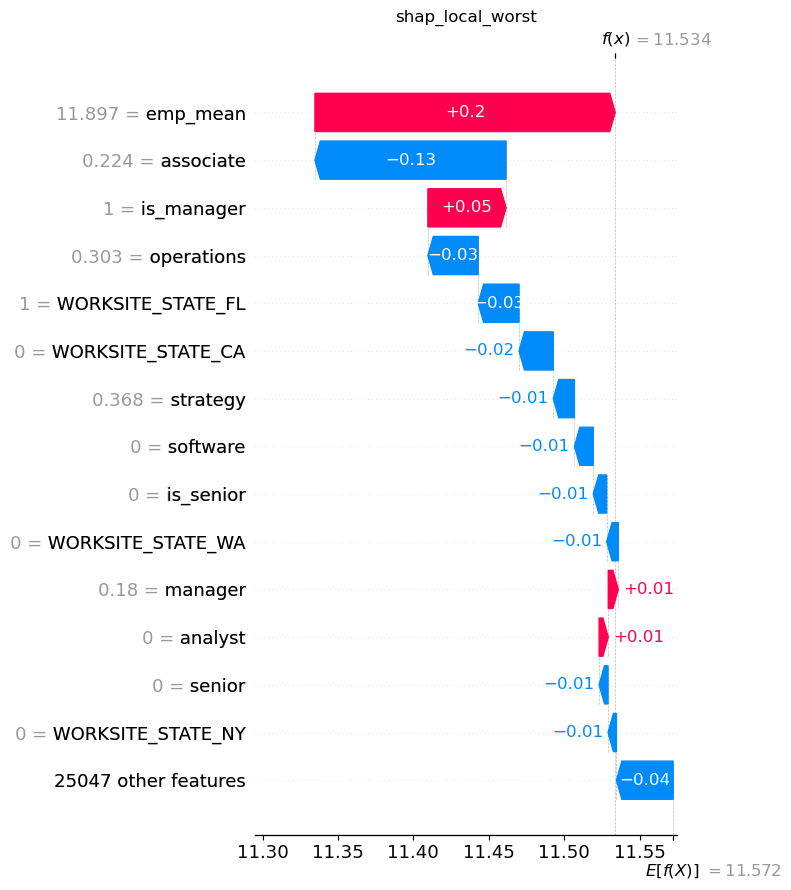

Saved: reports\figures\shap_local_worst.png
Best example abs error: 0.0006553876485781984
Worst example abs error: 0.7465126147709782


41470

In [13]:
# CODE BY GPT
# =============================================================================
# 8. SHAP (XGBoost tuned) - SAFE (smaller sample)
# =============================================================================
tfidf_names = list(tfidf.get_feature_names_out())
try:
    state_names = list(ohe.get_feature_names_out([STATE_COL]))
except Exception:
    state_names = [f"{STATE_COL}_{i}" for i in range(X_train_state.shape[1])]

feature_names = tfidf_names + state_names + ["emp_mean"] + flag_cols

SAMPLE_N = 250  # IMPORTANT: prevents huge dense shap_values matrix
rng = np.random.RandomState(SEED)
sample_idx = rng.choice(X_test_sparse.shape[0], size=min(SAMPLE_N, X_test_sparse.shape[0]), replace=False)

X_shap = X_test_sparse[sample_idx]
y_shap = y_test[sample_idx]
pred_shap = xgb_tuned.predict(X_shap)
abs_err = np.abs(y_shap - pred_shap)

best_i = int(np.argmin(abs_err))
worst_i = int(np.argmax(abs_err))

explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X_shap)

plt.figure()
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False, max_display=20)
save_show("shap_summary_beeswarm.png")

plt.figure()
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type="bar", show=False, max_display=20)
save_show("shap_importance_bar.png")

def save_local_explanation(idx_in_sample: int, out_name: str):
    vals = shap_values[idx_in_sample]
    base = explainer.expected_value
    x_row_dense = X_shap[idx_in_sample].toarray().reshape(-1)

    try:
        exp = shap.Explanation(values=vals, base_values=base, data=x_row_dense, feature_names=feature_names)
        plt.figure()
        shap.plots.waterfall(exp, max_display=15, show=False)
        plt.title(out_name.replace(".png", ""))
    except Exception as e:
        abs_vals = np.abs(vals)
        top = abs_vals.argsort()[::-1][:15]
        plt.figure()
        plt.barh(np.array(feature_names)[top][::-1], vals[top][::-1])
        plt.title(f"Local SHAP (fallback) — {out_name} | {type(e).__name__}")
        plt.xlabel("SHAP value")

    save_show(out_name)

save_local_explanation(best_i, "shap_local_best.png")
save_local_explanation(worst_i, "shap_local_worst.png")

print("Best example abs error:", abs_err[best_i])
print("Worst example abs error:", abs_err[worst_i])

del shap_values
gc.collect()

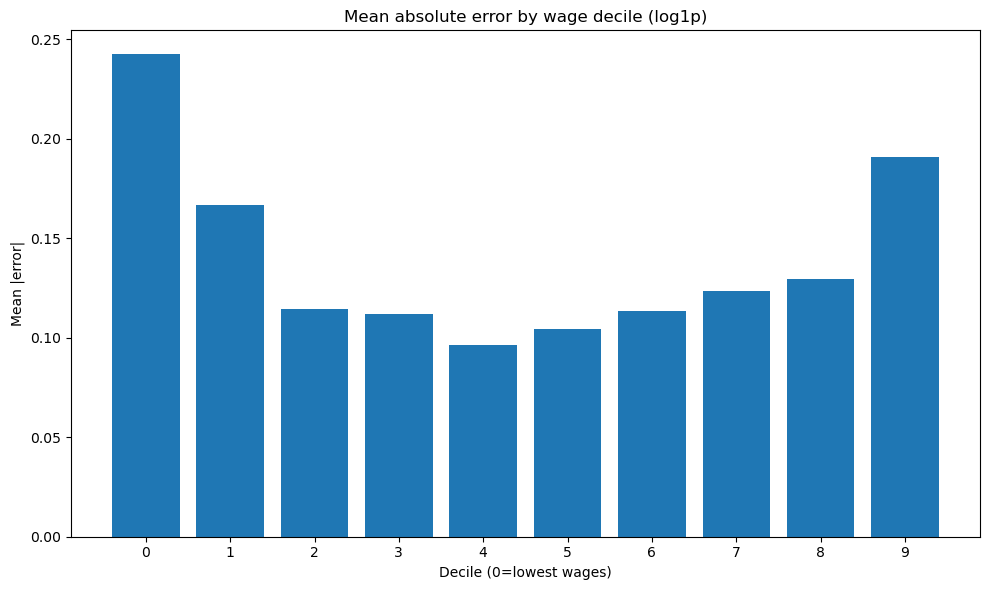

Saved: reports\figures\error_by_decile.png


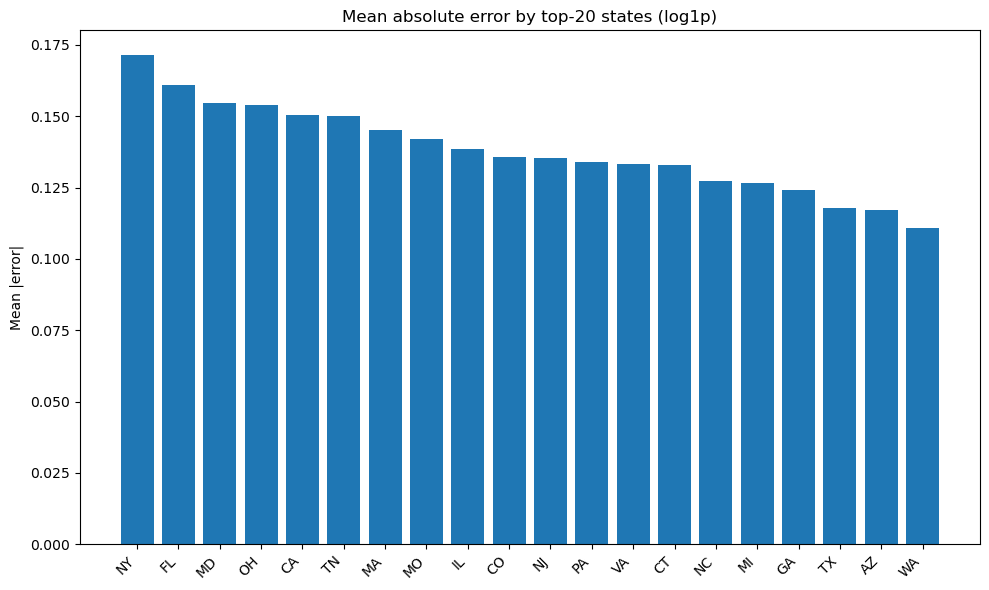

Saved: reports\figures\error_by_state_top20.png


In [14]:
# CODE BY GPT
# =============================================================================
# 8B. Error analysis plots on full test set
# =============================================================================
test_pred = xgb_tuned.predict(X_test_sparse)
test_abs_err = np.abs(y_test - test_pred)

test_tmp = test_df.copy()
test_tmp["pred_y_reg"] = test_pred
test_tmp["abs_err"] = test_abs_err
test_tmp["wage_decile"] = pd.qcut(test_tmp[TARGET_COL], 10, labels=False, duplicates="drop")

# Error by decile
dec = test_tmp.groupby("wage_decile")["abs_err"].mean()
plt.figure()
plt.bar(dec.index.astype(str), dec.values)
plt.title("Mean absolute error by wage decile (log1p)")
plt.xlabel("Decile (0=lowest wages)")
plt.ylabel("Mean |error|")
save_show("error_by_decile.png")

# Error by top-20 states
if STATE_COL in test_tmp.columns:
    top_states = test_tmp[STATE_COL].value_counts().head(20).index
    tmp = (test_tmp[test_tmp[STATE_COL].isin(top_states)]
           .groupby(STATE_COL)["abs_err"].mean()
           .sort_values(ascending=False))
    plt.figure()
    plt.bar(tmp.index.astype(str), tmp.values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Mean absolute error by top-20 states (log1p)")
    plt.ylabel("Mean |error|")
    save_show("error_by_state_top20.png")
else:
    print("Skip error_by_state_top20: STATE column not found.")

## 9) Unsupervised learning (KMeans + DBSCAN on job-title TF-IDF)
 
We validate the semantic structure of job titles:  
- TF-IDF on JOB_TITLE  
- TruncatedSVD for dimensionality reduction  
- KMeans with Elbow + Silhouette  
- DBSCAN small grid search  
- Link to wages: wage distribution by cluster  
- Interpret clusters by top words


Vectorizing & SVD...
Running KMeans Grid Search...


<Figure size 1000x600 with 0 Axes>

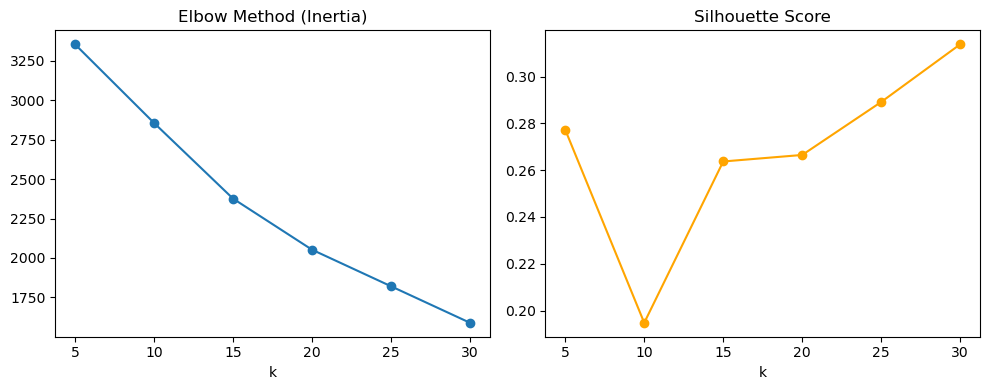

Saved: reports\figures\kmeans_elbow_silhouette.png
Fitting Final KMeans (k=20)...


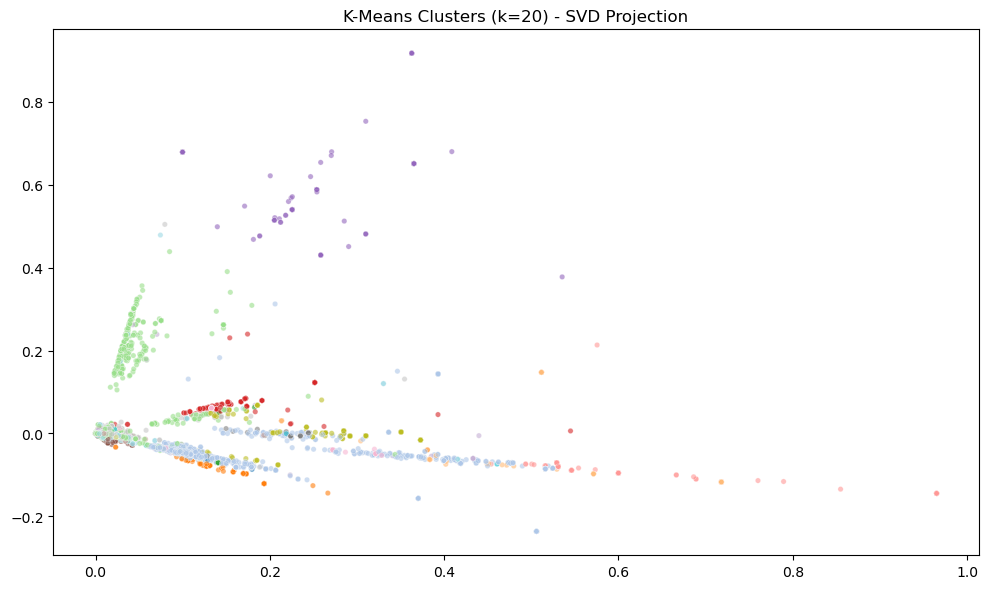

Saved: reports\figures\clusters_2d_kmeans.png


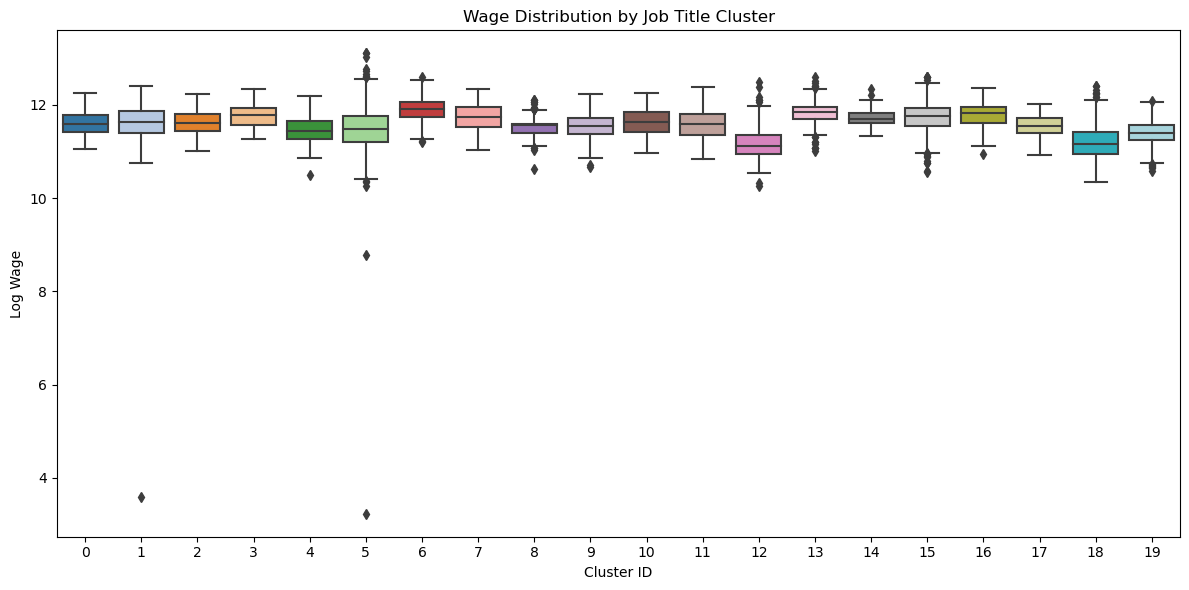

Saved: reports\figures\kmeans_wage_boxplot.png
Extracting top words per cluster...
✅ K-Means Analysis Complete.


,cluster,count,top_words
0,0,57,"process, process engineer, engineer, senior pr..."
1,1,1645,"engineer, senior, staff, software, software en..."
2,2,185,"data engineer, data, engineer, senior data, en..."
3,3,210,"senior software, senior, software engineer, so..."
4,4,184,"project, project manager, manager, project eng..."


In [17]:
# CODE BY GPT
# =============================================================================
# 9. Unsupervised: TF-IDF -> SVD -> KMeans/DBSCAN (use a sample for speed)
# =============================================================================
import seaborn as sns

UNSUP_SAMPLE = 10000   
SIL_SUB = 2500       

rng = np.random.RandomState(SEED)
idx_u = rng.choice(train_df.shape[0], size=min(UNSUP_SAMPLE, train_df.shape[0]), replace=False)

titles_u = train_df.iloc[idx_u][JOB_COL].fillna("").astype(str)
y_u_sample = train_df.iloc[idx_u][TARGET_COL].values # נשמור את השכר לגרפים

# --- 2. TF-IDF ו-SVD ---
print("Vectorizing & SVD...")
tfidf_u = TfidfVectorizer(
    max_features=15000,   # צמצום פיצ'רים
    ngram_range=(1,2),
    stop_words="english",
    min_df=3              # סינון רעש (מילים נדירות)
)
X_u = tfidf_u.fit_transform(titles_u)

svd_u = TruncatedSVD(n_components=50, random_state=SEED)
Z_u = svd_u.fit_transform(X_u)

# --- 3. לולאת KMeans (Elbow Method) ---
print("Running KMeans Grid Search...")
K_RANGE = list(range(5, 31, 5))
inertias, sil_scores = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(Z_u)
    inertias.append(km.inertia_)

    # Silhouette על תת-מדגם (מהיר)
    sub = rng.choice(len(labels), size=min(SIL_SUB, len(labels)), replace=False)
    sil = silhouette_score(Z_u[sub], labels[sub])
    sil_scores.append(sil)

# גרפים לבחירת K
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_RANGE, inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")

plt.subplot(1,2,2)
plt.plot(K_RANGE, sil_scores, marker="o", color="orange")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.tight_layout()
save_show("kmeans_elbow_silhouette.png")

# --- 4. הרצת המודל הסופי (K=20) ---
print("Fitting Final KMeans (k=20)...")
K_FINAL = 20
kmeans = KMeans(n_clusters=K_FINAL, random_state=SEED, n_init=10)
clusters = kmeans.fit_predict(Z_u)

# ויזואליזציה 1: פיזור בדו-מימד
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Z_u[:, 0], y=Z_u[:, 1], hue=clusters, palette="tab20", s=15, alpha=0.6, legend=False)
plt.title(f"K-Means Clusters (k={K_FINAL}) - SVD Projection")
save_show("clusters_2d_kmeans.png")

# ויזואליזציה 2: התפלגות שכר לפי קלאסטר
plt.figure(figsize=(12, 6))
sns.boxplot(x=clusters, y=y_u_sample, palette="tab20")
plt.title("Wage Distribution by Job Title Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Log Wage")
save_show("kmeans_wage_boxplot.png")

# --- 5. חילוץ מילים מובילות (Interpretation) ---
print("Extracting top words per cluster...")
terms = np.array(tfidf_u.get_feature_names_out())
X_u_dense = X_u.toarray() # בטוח כי הקטנו את המימדים והשורות

cluster_summary_list = []
for c in range(K_FINAL):
    idx_c = np.where(clusters == c)[0]
    if len(idx_c) == 0: continue
    
    mean_vec = X_u_dense[idx_c].mean(axis=0)
    top_idx = mean_vec.argsort()[::-1][:8]
    top_words = ", ".join(terms[top_idx])
    
    cluster_summary_list.append({
        "cluster": c,
        "count": len(idx_c),
        "top_words": top_words
    })

cluster_summary = pd.DataFrame(cluster_summary_list).sort_values("cluster")
cluster_summary.to_csv(REPORTS_DIR / "cluster_summary_kmeans.csv", index=False)

print("✅ K-Means Analysis Complete.")
display(cluster_summary.head())

In [18]:
# CODE BY GPT
# =============================================================================
# 9B. DBSCAN (small grid) on SVD representation
# =============================================================================
print("Starting DBSCAN Analysis...")

# דגימה קטנה ובטוחה ל-DBSCAN (אלגוריתם כבד)
DBSCAN_SUB = 5000
idx_db = rng.choice(Z_u.shape[0], size=min(DBSCAN_SUB, Z_u.shape[0]), replace=False)
Z_db = Z_u[idx_db]

print(f"Running DBSCAN on {len(Z_db)} samples...")

# גריד מצומצם ויעיל
eps_grid = [0.8, 1.0, 1.2]      
min_samples_grid = [10, 20]   

rows = []
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(Z_db)
        
        # חישוב מטריקות (התעלמות מרעש -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = float((labels == -1).mean())
        
        rows.append({
            "eps": eps, 
            "min_samples": ms, 
            "n_clusters": n_clusters, 
            "noise_frac": noise_frac
        })

# סיכום ושמירה
dbscan_df = pd.DataFrame(rows).sort_values(["n_clusters", "noise_frac"], ascending=[False, True])
dbscan_df.to_csv(REPORTS_DIR / "dbscan_grid_results.csv", index=False)

print("✅ DBSCAN Analysis Complete.")
display(dbscan_df)

# ניקוי סופי של כל הזיכרון בפרויקט
del X_u, X_u_dense, Z_u, Z_db, tfidf_u
gc.collect()

Starting DBSCAN Analysis...
Running DBSCAN on 5000 samples...
✅ DBSCAN Analysis Complete.


,eps,min_samples,n_clusters,noise_frac
0,0.8,10,2,0.0
1,0.8,20,2,0.0
2,1.0,10,1,0.0
3,1.0,20,1,0.0
4,1.2,10,1,0.0
5,1.2,20,1,0.0


42734

## 10) Executive summary (what to say in 60 seconds)

- **Winning model:** XGBoost on TF-IDF + State + Employer mean encoding + seniority flags  
- **Why:** handles sparse data well and captures non-linear interactions  
- **Top drivers:** title keywords, location, employer premium  
- **Confidence:** high due to held-out test set + learning curve + SHAP + unsupervised validation  
- **Limitations:** tails/outliers, academia-like roles with different pay mechanisms
